In [1]:
import os
import openai

from openai import OpenAI
from datasets import load_dataset
import json
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
client = OpenAI()



/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def llm2(prompt, **kwargs):
    response = client.chat.completions.create(
        model=kwargs.get("model", "gpt-3.5-turbo"),
        messages=[{"role": "system", "content": prompt}],
        temperature=kwargs.get("temperature", 0),
        top_p=kwargs.get("top_p", 1),
        frequency_penalty=kwargs.get("frequency_penalty", 0.0),
        presence_penalty=kwargs.get("presence_penalty", 0.0),
        max_tokens=kwargs.get("max_tokens", 500),
        n=kwargs.get("n", 1),
    )
    return response

## Experiment 1
AIM: To quantify the consistency of ragas recall score 

- before prompt change
- After prompt change
- Prompt change + self consistency method

Quantify 
- KL divergance
- Mean absolute change (x_i - y_i)
- Mean of scores

Dataset used:
- explodinggradients/WikiEval

In [3]:
#  with open("consistency_recall.json",'w') as file:
#          json.dump({}, file, indent=4)

In [4]:
def read_score(name):
    filename = "consistency_recall.json"
    data = json.load(open(filename))
    return data.get(name)

In [5]:
def record_score(score,name):
    
    filename = "consistency_recall.json"
    data = json.load(open(filename))
    data[name] = score
    with open(filename,'w') as file:
        json.dump(data, file, indent=4)
        

In [6]:
def KL(dist1,dist2):
    
    if isinstance(dist1, list):
        dist1 = np.array(dist1) + 1e-8
        
    if isinstance(dist2, list):
        dist2 = np.array(dist2) + 1e-8
        
    dist1_normalized = dist1 / dist1.sum()
    dist2_normalized = dist2 / dist2.sum()
    kl_divergence = entropy(dist1_normalized, dist2_normalized)
    return kl_divergence

In [100]:
recall_prompt = """
Given a context, and an answer, analyze each sentence in the answer and classify if the sentence can be attributed to the given context or not. Output json with reason.


question: What can you tell me about albert Albert Einstein?
context: Albert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist,widely held to be one of the greatest and most influential scientists of all time. Best known for developing the theory of relativity, he also made important contributions to quantum mechanics, and was thus a central figure in the revolutionary reshaping of the scientific understanding of nature that modern physics accomplished in the first decades of the twentieth century. His mass–energy equivalence formula E = mc2, which arises from relativity theory, has been called "the world's most famous equation". He received the 1921 Nobel Prize in Physics "for his services to theoretical physics, and especially for his discovery of the law of the photoelectric effect", a pivotal step in the development of quantum theory. His work is also known for its influence on the philosophy of science. In a 1999 poll of 130 leading physicists worldwide by the British journal Physics World, Einstein was ranked the greatest physicist of all time. His intellectual achievements and originality have made Einstein synonymous with genius.
answer: Albert Einstein born in 14 March 1879 was  German-born theoretical physicist, widely held to be one of the greatest and most influential scientists of all time. He received the 1921 Nobel Prize in Physics "for his services to theoretical physics. He published 4 papers in 1905.  Einstein moved to Switzerland in 1895 
classification:
[
    {{  "statement_1":"Albert Einstein, born on 14 March 1879, was a German-born theoretical physicist, widely held to be one of the greatest and most influential scientists of all time.",
        "reason": "The date of birth of Einstein is mentioned clearly in the context.",
        "Attributed": "Yes"
    }},
    {{
        "statement_2":"He received the 1921 Nobel Prize in Physics 'for his services to theoretical physics.",
        "reason": "The exact sentence is present in the given context.",
        "Attributed": "Yes"
    }},
    {{
        "statement_3": "He published 4 papers in 1905.",
        "reason": "There is no mention about papers he wrote in the given context.",
        "Attributed": "No"
    }},
    {{
        "statement_4":"Einstein moved to Switzerland in 1895.",
        "reason": "There is no supporting evidence for this in the given context.",
        "Attributed": "No"
    }}
]

question: who won 2020 icc world cup?
context: Who won the 2022 ICC Men's T20 World Cup?
The 2022 ICC Men's T20 World Cup, held from October 16 to November 13, 2022, in Australia, was the eighth edition of the tournament. Originally scheduled for 2020, it was postponed due to the COVID-19 pandemic. England emerged victorious, defeating Pakistan by five wickets in the final to clinch their second ICC Men's T20 World Cup title.
answer: England 
classification: 
[
    {{
        "statement_1":"England won the 2022 ICC Men's T20 World Cup.",
        "reason": "From context it is clear that England defeated Pakistan to win the World Cup.",
         "Attributed": "Yes"
    }}
]

question:{question}
context:{context}
answer:{answer}
classification:"""

In [101]:
c = """
Black holes, one of the most enigmatic and fascinating phenomena in the universe, are regions of spacetime where gravity is so intense that nothing, not even light, can escape their grasp. Formed from the remnants of massive stars that have undergone gravitational collapse, black holes are characterized by their event horizon, a boundary beyond which all matter and radiation are irretrievably pulled in. Intriguingly, while they are invisible, their presence can be inferred through their interaction with nearby matter and the emission of high-energy radiation. Black holes challenge our understanding of physics, particularly at the intersection of quantum mechanics and general relativity, presenting intriguing questions about the nature of space, time, and the fabric of the universe itself.
"""
q = "What is the term used to describe the boundary around a black hole where nothing, not even light, can escape?"
a = "Event Horizon."

In [102]:
output = llm2(recall_prompt.format(context=c,question=q,answer=a))

In [103]:
eval(output.choices[0].message.content)

[{'statement_1': 'The term used to describe the boundary around a black hole where nothing, not even light, can escape is the event horizon.',
  'reason': "The exact term 'event horizon' is mentioned in the context.",
  'Attributed': 'Yes'}]

In [108]:
output.choices[0].message.content

'[\n    {\n        "statement_1":"The term used to describe the boundary around a black hole where nothing, not even light, can escape is the event horizon.",\n        "reason": "The exact term \'event horizon\' is mentioned in the context.",\n        "Attributed": "Yes"\n    }\n]'

In [121]:
eval(match.group())

[{'statement_1': 'The term used to describe the boundary around a black hole where nothing, not even light, can escape is the event horizon.',
  'reason': "The exact term 'event horizon' is mentioned in the context.",
  'Attributed': 'Yes'}]

In [4]:
# dataset = load_dataset("explodinggradients/WikiEval")
dataset = load_dataset("Pakulski/ELI5-test")

Found cached dataset parquet (/Users/shahules/.cache/huggingface/datasets/Pakulski___parquet/Pakulski--ELI5-test-ed159b4d22db0b30/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


In [3]:
from ragas.metrics import context_recall


In [6]:
# from ragas.metrics._context_recall import ContextRecallImproved
# context_recall = ContextRecallImproved()

In [7]:
from ragas import evaluate

In [8]:
dataset = dataset['train'].select(range(0,10))
dataset = dataset.rename_columns({"document":"contexts","goldenAnswer":"ground_truths"})
dataset = dataset.map(lambda x : {'ground_truths':[x['ground_truths']],'contexts':[x['contexts']] })

In [17]:
# dataset = dataset['train'].map(lambda x : {'ground_truths':[x['ungrounded_answer']]})

Loading cached processed dataset at /Users/shahules/.cache/huggingface/datasets/explodinggradients___parquet/explodinggradients--WikiEval-33bd2cbc490cc57b/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-5fe04aab11621603.arrow


In [53]:
dataset

Dataset({
    features: ['id', 'question', 'contexts', 'ground_truths'],
    num_rows: 100
})

In [22]:
# ragas_score = evaluate(dataset=dataset,metrics=[context_recall],column_map={"question":"question","contexts":"context_v1","ground_truths":"ground_truths"})

evaluating with [context_recall]


100%|█████████████████████████████████████████████████████| 4/4 [01:13<00:00, 18.34s/it]


In [9]:
ragas_score = evaluate(dataset=dataset,metrics=[context_recall])

evaluating with [context_recall]


100%|█████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.22s/it]


In [64]:
record_score(ragas_score.to_pandas()['context_recall'].values.tolist(),'prompt_to_json_eli5_1')

In [65]:
score = KL(read_score("prompt_to_json_eli5"),read_score("prompt_to_json_eli5_1"))

In [66]:
score

0.0

In [29]:
record_score(score,"prompt_to_json_prompt_to_json_2")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


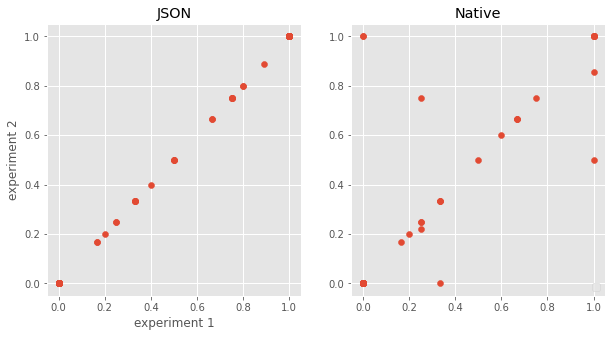

In [98]:
plt.style.use('ggplot') 
fig,ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].scatter(read_score("prompt_to_json_eli5"),read_score("prompt_to_json_eli5_1"),marker="o")
ax[0].set_title("JSON")
ax[1].scatter(read_score("native_eli5"),read_score("native_eli5_1"),marker="o")
ax[1].set_title("Native")
ax[0].set_xlabel("experiment 1")
ax[0].set_ylabel("experiment 2")

plt.legend()
plt.show()

## Self consistency 
The idea is to select the sample with highest similarity to other samples, among k generated samples
1) n-gram + cosine similarity

2) embeddings + cosine similarity

### Use case
- building this to select the best from k generations that are all json
- For each json in output
    - for each key in json
        - select sample with that maximises sim score 